In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio
pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px

## 1. Import dataset

In [2]:
data_dir = 'dataset'
### With these commands the train and test datasets, respectively, are downloaded
### automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Using downloaded and verified file: dataset\MNIST\raw\train-images-idx3-ubyte.gz
Extracting dataset\MNIST\raw\train-images-idx3-ubyte.gz to dataset\MNIST\raw
Using downloaded and verified file: dataset\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting dataset\MNIST\raw\train-labels-idx1-ubyte.gz to dataset\MNIST\raw


1649664it [00:06, 274681.86it/s]                             


Extracting dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to dataset\MNIST\raw


5120it [00:00, ?it/s]                   

Extracting dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to dataset\MNIST\raw
Processing...
Done!



C:\Users\1\Anaconda3\envs\py38\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)



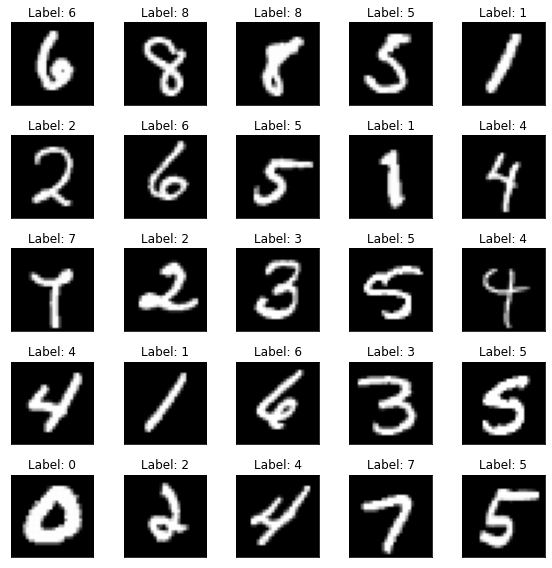

In [5]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [6]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [7]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 2. Define Convolutional Autoencoder

In [9]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [10]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

## 3. Initialize Loss function and the optimizer

In [11]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)

In [28]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
print(img.shape)
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image

img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)

# Decode the image
dec_img = decoder(img_enc)
#dec_img = model(img)
print('Decoded image shape:', dec_img.shape)

torch.Size([1, 28, 28])
Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 4])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [29]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)
#optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)
#model.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## 4. Train and evaluate model

In [31]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [32]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [33]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 0.252835
	 partial train loss (single batch): 0.246529
	 partial train loss (single batch): 0.240699
	 partial train loss (single batch): 0.236194
	 partial train loss (single batch): 0.231886
	 partial train loss (single batch): 0.228616
	 partial train loss (single batch): 0.225478
	 partial train loss (single batch): 0.223000
	 partial train loss (single batch): 0.220820
	 partial train loss (single batch): 0.218105
	 partial train loss (single batch): 0.215600
	 partial train loss (single batch): 0.213716
	 partial train loss (single batch): 0.211699
	 partial train loss (single batch): 0.209325
	 partial train loss (single batch): 0.207205
	 partial train loss (single batch): 0.205440
	 partial train loss (single batch): 0.203443
	 partial train loss (single batch): 0.201685
	 partial train loss (single batch): 0.199435
	 partial train loss (single batch): 0.197416
	 partial train loss (single batch): 0.195991
	 partial train loss (single batch

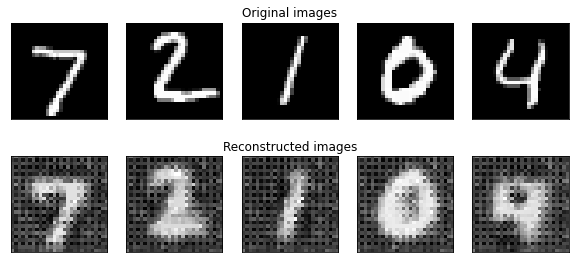

	 partial train loss (single batch): 0.067457
	 partial train loss (single batch): 0.064209
	 partial train loss (single batch): 0.064743
	 partial train loss (single batch): 0.064568
	 partial train loss (single batch): 0.065543
	 partial train loss (single batch): 0.064940
	 partial train loss (single batch): 0.064003
	 partial train loss (single batch): 0.065112
	 partial train loss (single batch): 0.063496
	 partial train loss (single batch): 0.063630
	 partial train loss (single batch): 0.064542
	 partial train loss (single batch): 0.063089
	 partial train loss (single batch): 0.062595
	 partial train loss (single batch): 0.063000
	 partial train loss (single batch): 0.061106
	 partial train loss (single batch): 0.063120
	 partial train loss (single batch): 0.062679
	 partial train loss (single batch): 0.062232
	 partial train loss (single batch): 0.060748
	 partial train loss (single batch): 0.061583
	 partial train loss (single batch): 0.061906
	 partial train loss (single batch

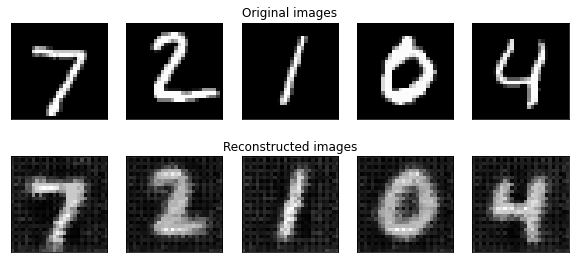

	 partial train loss (single batch): 0.049466
	 partial train loss (single batch): 0.045698
	 partial train loss (single batch): 0.046855
	 partial train loss (single batch): 0.047056
	 partial train loss (single batch): 0.048031
	 partial train loss (single batch): 0.047347
	 partial train loss (single batch): 0.046543
	 partial train loss (single batch): 0.047945
	 partial train loss (single batch): 0.046757
	 partial train loss (single batch): 0.046809
	 partial train loss (single batch): 0.047987
	 partial train loss (single batch): 0.046508
	 partial train loss (single batch): 0.046030
	 partial train loss (single batch): 0.046606
	 partial train loss (single batch): 0.044788
	 partial train loss (single batch): 0.047261
	 partial train loss (single batch): 0.046812
	 partial train loss (single batch): 0.046439
	 partial train loss (single batch): 0.045258
	 partial train loss (single batch): 0.046152
	 partial train loss (single batch): 0.046355
	 partial train loss (single batch

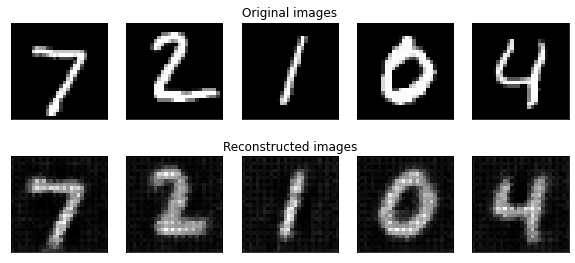

	 partial train loss (single batch): 0.040508
	 partial train loss (single batch): 0.037017
	 partial train loss (single batch): 0.038023
	 partial train loss (single batch): 0.038351
	 partial train loss (single batch): 0.039771
	 partial train loss (single batch): 0.038391
	 partial train loss (single batch): 0.037929
	 partial train loss (single batch): 0.039490
	 partial train loss (single batch): 0.038318
	 partial train loss (single batch): 0.037966
	 partial train loss (single batch): 0.039283
	 partial train loss (single batch): 0.038018
	 partial train loss (single batch): 0.037298
	 partial train loss (single batch): 0.037773
	 partial train loss (single batch): 0.036865
	 partial train loss (single batch): 0.038739
	 partial train loss (single batch): 0.037882
	 partial train loss (single batch): 0.037812
	 partial train loss (single batch): 0.037203
	 partial train loss (single batch): 0.037323
	 partial train loss (single batch): 0.037959
	 partial train loss (single batch

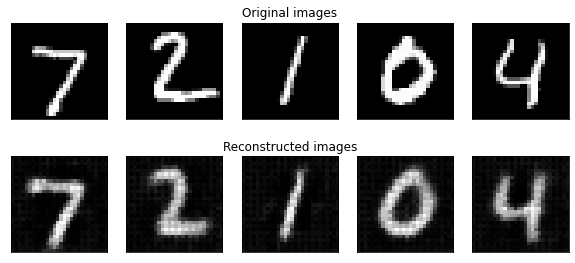

	 partial train loss (single batch): 0.035679
	 partial train loss (single batch): 0.032118
	 partial train loss (single batch): 0.033375
	 partial train loss (single batch): 0.033590
	 partial train loss (single batch): 0.034817
	 partial train loss (single batch): 0.033560
	 partial train loss (single batch): 0.033120
	 partial train loss (single batch): 0.034750
	 partial train loss (single batch): 0.033971
	 partial train loss (single batch): 0.032833
	 partial train loss (single batch): 0.034422
	 partial train loss (single batch): 0.033156
	 partial train loss (single batch): 0.032256
	 partial train loss (single batch): 0.032887
	 partial train loss (single batch): 0.032338
	 partial train loss (single batch): 0.033846
	 partial train loss (single batch): 0.033075
	 partial train loss (single batch): 0.033153
	 partial train loss (single batch): 0.032895
	 partial train loss (single batch): 0.032390
	 partial train loss (single batch): 0.033181
	 partial train loss (single batch

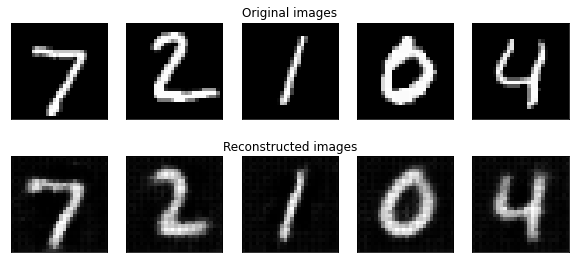

	 partial train loss (single batch): 0.033399
	 partial train loss (single batch): 0.030076
	 partial train loss (single batch): 0.031233
	 partial train loss (single batch): 0.031477
	 partial train loss (single batch): 0.032574
	 partial train loss (single batch): 0.031376
	 partial train loss (single batch): 0.031058
	 partial train loss (single batch): 0.032598
	 partial train loss (single batch): 0.032061
	 partial train loss (single batch): 0.030909
	 partial train loss (single batch): 0.032283
	 partial train loss (single batch): 0.030900
	 partial train loss (single batch): 0.030161
	 partial train loss (single batch): 0.030847
	 partial train loss (single batch): 0.030415
	 partial train loss (single batch): 0.031680
	 partial train loss (single batch): 0.030985
	 partial train loss (single batch): 0.031219
	 partial train loss (single batch): 0.030889
	 partial train loss (single batch): 0.030257
	 partial train loss (single batch): 0.031224
	 partial train loss (single batch

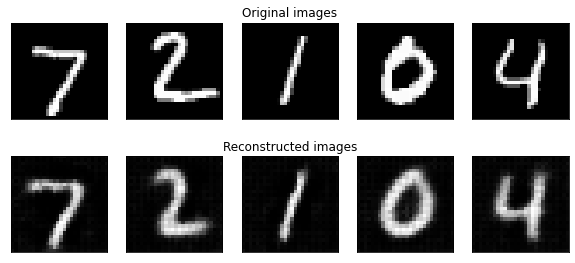

	 partial train loss (single batch): 0.032019
	 partial train loss (single batch): 0.028932
	 partial train loss (single batch): 0.029985
	 partial train loss (single batch): 0.030197
	 partial train loss (single batch): 0.031076
	 partial train loss (single batch): 0.030086
	 partial train loss (single batch): 0.029988
	 partial train loss (single batch): 0.031464
	 partial train loss (single batch): 0.030817
	 partial train loss (single batch): 0.029772
	 partial train loss (single batch): 0.030956
	 partial train loss (single batch): 0.029565
	 partial train loss (single batch): 0.028962
	 partial train loss (single batch): 0.029483
	 partial train loss (single batch): 0.029277
	 partial train loss (single batch): 0.030281
	 partial train loss (single batch): 0.029621
	 partial train loss (single batch): 0.030088
	 partial train loss (single batch): 0.029673
	 partial train loss (single batch): 0.029095
	 partial train loss (single batch): 0.030083
	 partial train loss (single batch

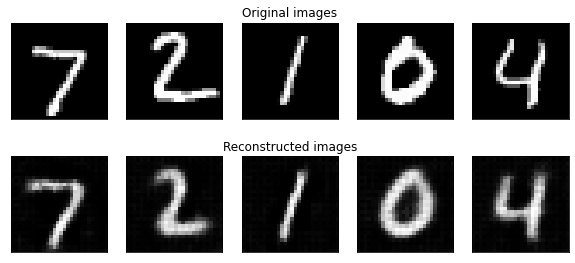

	 partial train loss (single batch): 0.031103
	 partial train loss (single batch): 0.028198
	 partial train loss (single batch): 0.029228
	 partial train loss (single batch): 0.029350
	 partial train loss (single batch): 0.030091
	 partial train loss (single batch): 0.029340
	 partial train loss (single batch): 0.029294
	 partial train loss (single batch): 0.030750
	 partial train loss (single batch): 0.029957
	 partial train loss (single batch): 0.029124
	 partial train loss (single batch): 0.030167
	 partial train loss (single batch): 0.028792
	 partial train loss (single batch): 0.028404
	 partial train loss (single batch): 0.028703
	 partial train loss (single batch): 0.028607
	 partial train loss (single batch): 0.029511
	 partial train loss (single batch): 0.028881
	 partial train loss (single batch): 0.029434
	 partial train loss (single batch): 0.029106
	 partial train loss (single batch): 0.028325
	 partial train loss (single batch): 0.029312
	 partial train loss (single batch

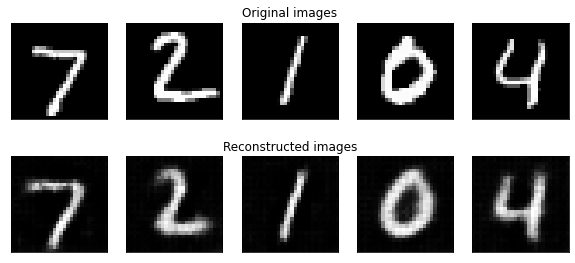

	 partial train loss (single batch): 0.030522
	 partial train loss (single batch): 0.027674
	 partial train loss (single batch): 0.028592
	 partial train loss (single batch): 0.028640
	 partial train loss (single batch): 0.029459
	 partial train loss (single batch): 0.028813
	 partial train loss (single batch): 0.028762
	 partial train loss (single batch): 0.030160
	 partial train loss (single batch): 0.029342
	 partial train loss (single batch): 0.028630
	 partial train loss (single batch): 0.029630
	 partial train loss (single batch): 0.028329
	 partial train loss (single batch): 0.028035
	 partial train loss (single batch): 0.027968
	 partial train loss (single batch): 0.028018
	 partial train loss (single batch): 0.029000
	 partial train loss (single batch): 0.028243
	 partial train loss (single batch): 0.028841
	 partial train loss (single batch): 0.028512
	 partial train loss (single batch): 0.027722
	 partial train loss (single batch): 0.028866
	 partial train loss (single batch

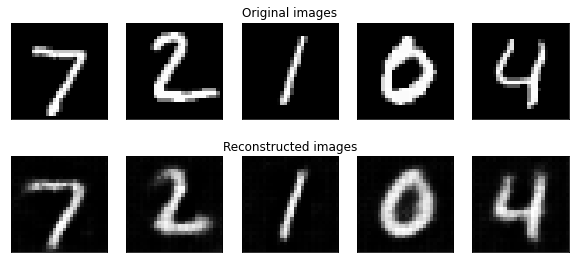

	 partial train loss (single batch): 0.030029
	 partial train loss (single batch): 0.027285
	 partial train loss (single batch): 0.028007
	 partial train loss (single batch): 0.027953
	 partial train loss (single batch): 0.028944
	 partial train loss (single batch): 0.028449
	 partial train loss (single batch): 0.028311
	 partial train loss (single batch): 0.029700
	 partial train loss (single batch): 0.028945
	 partial train loss (single batch): 0.028200
	 partial train loss (single batch): 0.029261
	 partial train loss (single batch): 0.028015
	 partial train loss (single batch): 0.027690
	 partial train loss (single batch): 0.027560
	 partial train loss (single batch): 0.027694
	 partial train loss (single batch): 0.028551
	 partial train loss (single batch): 0.027832
	 partial train loss (single batch): 0.028302
	 partial train loss (single batch): 0.028097
	 partial train loss (single batch): 0.027385
	 partial train loss (single batch): 0.028499
	 partial train loss (single batch

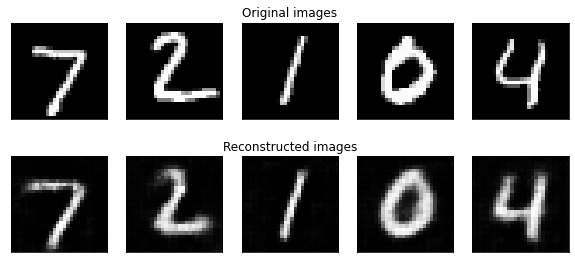

	 partial train loss (single batch): 0.029538
	 partial train loss (single batch): 0.026866
	 partial train loss (single batch): 0.027533
	 partial train loss (single batch): 0.027407
	 partial train loss (single batch): 0.028545
	 partial train loss (single batch): 0.028064
	 partial train loss (single batch): 0.027916
	 partial train loss (single batch): 0.029392
	 partial train loss (single batch): 0.028547
	 partial train loss (single batch): 0.027903
	 partial train loss (single batch): 0.028767
	 partial train loss (single batch): 0.027618
	 partial train loss (single batch): 0.027363
	 partial train loss (single batch): 0.027118
	 partial train loss (single batch): 0.027203
	 partial train loss (single batch): 0.028134
	 partial train loss (single batch): 0.027376
	 partial train loss (single batch): 0.027938
	 partial train loss (single batch): 0.027671
	 partial train loss (single batch): 0.026920
	 partial train loss (single batch): 0.028151
	 partial train loss (single batch

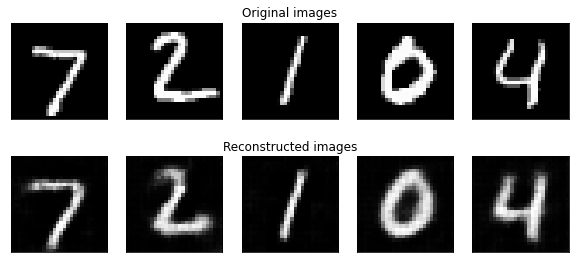

	 partial train loss (single batch): 0.029151
	 partial train loss (single batch): 0.026500
	 partial train loss (single batch): 0.027091
	 partial train loss (single batch): 0.026981
	 partial train loss (single batch): 0.028103
	 partial train loss (single batch): 0.027647
	 partial train loss (single batch): 0.027520
	 partial train loss (single batch): 0.029007
	 partial train loss (single batch): 0.028159
	 partial train loss (single batch): 0.027546
	 partial train loss (single batch): 0.028456
	 partial train loss (single batch): 0.027303
	 partial train loss (single batch): 0.027053
	 partial train loss (single batch): 0.026695
	 partial train loss (single batch): 0.026886
	 partial train loss (single batch): 0.027835
	 partial train loss (single batch): 0.026948
	 partial train loss (single batch): 0.027599
	 partial train loss (single batch): 0.027198
	 partial train loss (single batch): 0.026492
	 partial train loss (single batch): 0.027840
	 partial train loss (single batch

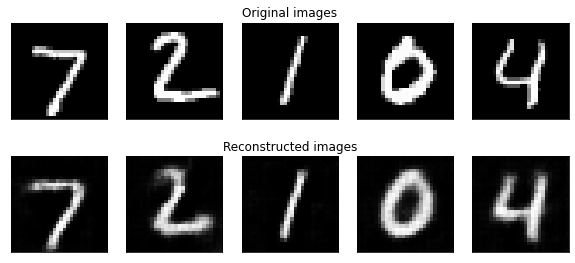

	 partial train loss (single batch): 0.028881
	 partial train loss (single batch): 0.026254
	 partial train loss (single batch): 0.026807
	 partial train loss (single batch): 0.026797
	 partial train loss (single batch): 0.027913
	 partial train loss (single batch): 0.027390
	 partial train loss (single batch): 0.027273
	 partial train loss (single batch): 0.028845
	 partial train loss (single batch): 0.028002
	 partial train loss (single batch): 0.027315
	 partial train loss (single batch): 0.028172
	 partial train loss (single batch): 0.027031
	 partial train loss (single batch): 0.026771
	 partial train loss (single batch): 0.026467
	 partial train loss (single batch): 0.026509
	 partial train loss (single batch): 0.027500
	 partial train loss (single batch): 0.026635
	 partial train loss (single batch): 0.027279
	 partial train loss (single batch): 0.026883
	 partial train loss (single batch): 0.026275
	 partial train loss (single batch): 0.027608
	 partial train loss (single batch

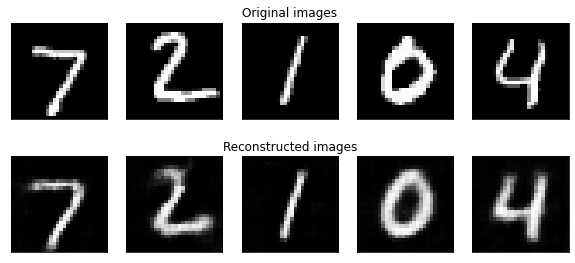

	 partial train loss (single batch): 0.028677
	 partial train loss (single batch): 0.025970
	 partial train loss (single batch): 0.026588
	 partial train loss (single batch): 0.026590
	 partial train loss (single batch): 0.027621
	 partial train loss (single batch): 0.027106
	 partial train loss (single batch): 0.027105
	 partial train loss (single batch): 0.028605
	 partial train loss (single batch): 0.027754
	 partial train loss (single batch): 0.027198
	 partial train loss (single batch): 0.027894
	 partial train loss (single batch): 0.026750
	 partial train loss (single batch): 0.026527
	 partial train loss (single batch): 0.026233
	 partial train loss (single batch): 0.026255
	 partial train loss (single batch): 0.027257
	 partial train loss (single batch): 0.026369
	 partial train loss (single batch): 0.027025
	 partial train loss (single batch): 0.026630
	 partial train loss (single batch): 0.025930
	 partial train loss (single batch): 0.027351
	 partial train loss (single batch

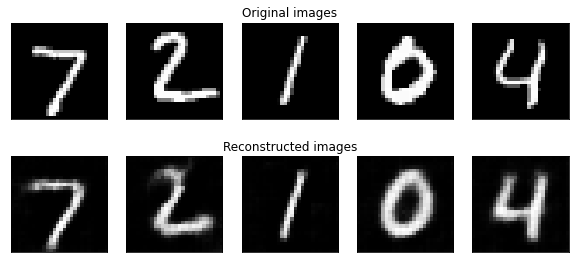

	 partial train loss (single batch): 0.028536
	 partial train loss (single batch): 0.025767
	 partial train loss (single batch): 0.026375
	 partial train loss (single batch): 0.026381
	 partial train loss (single batch): 0.027470
	 partial train loss (single batch): 0.026896
	 partial train loss (single batch): 0.026924
	 partial train loss (single batch): 0.028418
	 partial train loss (single batch): 0.027438
	 partial train loss (single batch): 0.026978
	 partial train loss (single batch): 0.027667
	 partial train loss (single batch): 0.026563
	 partial train loss (single batch): 0.026285
	 partial train loss (single batch): 0.026037
	 partial train loss (single batch): 0.025966
	 partial train loss (single batch): 0.027081
	 partial train loss (single batch): 0.026137
	 partial train loss (single batch): 0.026816
	 partial train loss (single batch): 0.026447
	 partial train loss (single batch): 0.025684
	 partial train loss (single batch): 0.027101
	 partial train loss (single batch

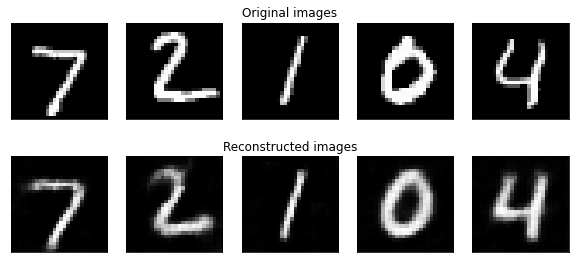

	 partial train loss (single batch): 0.028361
	 partial train loss (single batch): 0.025579
	 partial train loss (single batch): 0.026133
	 partial train loss (single batch): 0.026120
	 partial train loss (single batch): 0.027266
	 partial train loss (single batch): 0.026682
	 partial train loss (single batch): 0.026733
	 partial train loss (single batch): 0.028262
	 partial train loss (single batch): 0.027269
	 partial train loss (single batch): 0.026788
	 partial train loss (single batch): 0.027411
	 partial train loss (single batch): 0.026324
	 partial train loss (single batch): 0.026136
	 partial train loss (single batch): 0.025903
	 partial train loss (single batch): 0.025838
	 partial train loss (single batch): 0.026894
	 partial train loss (single batch): 0.025957
	 partial train loss (single batch): 0.026617
	 partial train loss (single batch): 0.026250
	 partial train loss (single batch): 0.025579
	 partial train loss (single batch): 0.026973
	 partial train loss (single batch

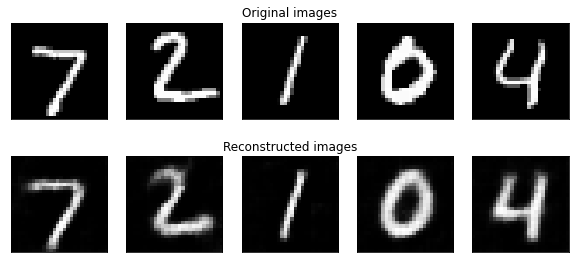

	 partial train loss (single batch): 0.028186
	 partial train loss (single batch): 0.025487
	 partial train loss (single batch): 0.026075
	 partial train loss (single batch): 0.025910
	 partial train loss (single batch): 0.027075
	 partial train loss (single batch): 0.026534
	 partial train loss (single batch): 0.026630
	 partial train loss (single batch): 0.028180
	 partial train loss (single batch): 0.027176
	 partial train loss (single batch): 0.026706
	 partial train loss (single batch): 0.027234
	 partial train loss (single batch): 0.026223
	 partial train loss (single batch): 0.025976
	 partial train loss (single batch): 0.025844
	 partial train loss (single batch): 0.025692
	 partial train loss (single batch): 0.026786
	 partial train loss (single batch): 0.025885
	 partial train loss (single batch): 0.026527
	 partial train loss (single batch): 0.026129
	 partial train loss (single batch): 0.025472
	 partial train loss (single batch): 0.026840
	 partial train loss (single batch

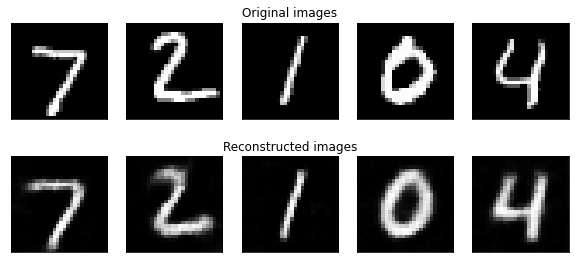

	 partial train loss (single batch): 0.027972
	 partial train loss (single batch): 0.025335
	 partial train loss (single batch): 0.025982
	 partial train loss (single batch): 0.025717
	 partial train loss (single batch): 0.026898
	 partial train loss (single batch): 0.026361
	 partial train loss (single batch): 0.026422
	 partial train loss (single batch): 0.028011
	 partial train loss (single batch): 0.026929
	 partial train loss (single batch): 0.026513
	 partial train loss (single batch): 0.027071
	 partial train loss (single batch): 0.026045
	 partial train loss (single batch): 0.025769
	 partial train loss (single batch): 0.025701
	 partial train loss (single batch): 0.025530
	 partial train loss (single batch): 0.026588
	 partial train loss (single batch): 0.025731
	 partial train loss (single batch): 0.026374
	 partial train loss (single batch): 0.025943
	 partial train loss (single batch): 0.025316
	 partial train loss (single batch): 0.026657
	 partial train loss (single batch

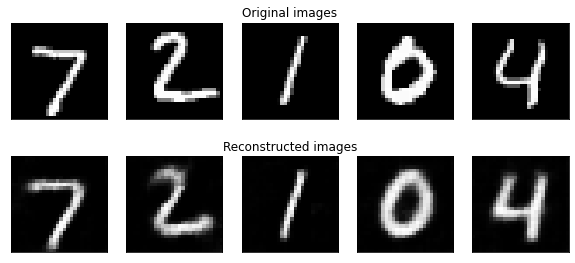

	 partial train loss (single batch): 0.027917
	 partial train loss (single batch): 0.025240
	 partial train loss (single batch): 0.025872
	 partial train loss (single batch): 0.025646
	 partial train loss (single batch): 0.026829
	 partial train loss (single batch): 0.026225
	 partial train loss (single batch): 0.026382
	 partial train loss (single batch): 0.027938
	 partial train loss (single batch): 0.026833
	 partial train loss (single batch): 0.026402
	 partial train loss (single batch): 0.026996
	 partial train loss (single batch): 0.025988
	 partial train loss (single batch): 0.025631
	 partial train loss (single batch): 0.025594
	 partial train loss (single batch): 0.025428
	 partial train loss (single batch): 0.026482
	 partial train loss (single batch): 0.025680
	 partial train loss (single batch): 0.026191
	 partial train loss (single batch): 0.025863
	 partial train loss (single batch): 0.025212
	 partial train loss (single batch): 0.026555
	 partial train loss (single batch

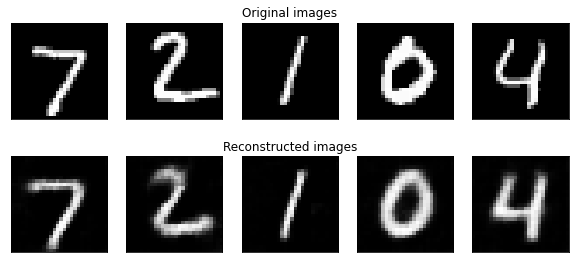

	 partial train loss (single batch): 0.027759
	 partial train loss (single batch): 0.025069
	 partial train loss (single batch): 0.025756
	 partial train loss (single batch): 0.025442
	 partial train loss (single batch): 0.026699
	 partial train loss (single batch): 0.026034
	 partial train loss (single batch): 0.026234
	 partial train loss (single batch): 0.027781
	 partial train loss (single batch): 0.026650
	 partial train loss (single batch): 0.026247
	 partial train loss (single batch): 0.026853
	 partial train loss (single batch): 0.025865
	 partial train loss (single batch): 0.025507
	 partial train loss (single batch): 0.025466
	 partial train loss (single batch): 0.025251
	 partial train loss (single batch): 0.026330
	 partial train loss (single batch): 0.025604
	 partial train loss (single batch): 0.026037
	 partial train loss (single batch): 0.025765
	 partial train loss (single batch): 0.025017
	 partial train loss (single batch): 0.026487
	 partial train loss (single batch

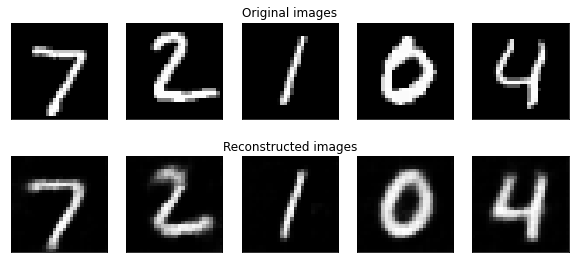

	 partial train loss (single batch): 0.027616
	 partial train loss (single batch): 0.024923
	 partial train loss (single batch): 0.025607
	 partial train loss (single batch): 0.025300
	 partial train loss (single batch): 0.026648
	 partial train loss (single batch): 0.025944
	 partial train loss (single batch): 0.026104
	 partial train loss (single batch): 0.027613
	 partial train loss (single batch): 0.026563
	 partial train loss (single batch): 0.026186
	 partial train loss (single batch): 0.026791
	 partial train loss (single batch): 0.025740
	 partial train loss (single batch): 0.025358
	 partial train loss (single batch): 0.025407
	 partial train loss (single batch): 0.025273
	 partial train loss (single batch): 0.026265
	 partial train loss (single batch): 0.025544
	 partial train loss (single batch): 0.025962
	 partial train loss (single batch): 0.025687
	 partial train loss (single batch): 0.024908
	 partial train loss (single batch): 0.026410
	 partial train loss (single batch

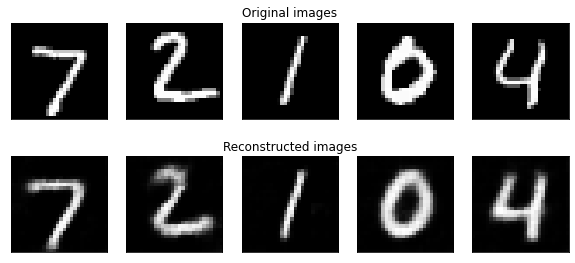

	 partial train loss (single batch): 0.027459
	 partial train loss (single batch): 0.024759
	 partial train loss (single batch): 0.025532
	 partial train loss (single batch): 0.025083
	 partial train loss (single batch): 0.026546
	 partial train loss (single batch): 0.025821
	 partial train loss (single batch): 0.026035
	 partial train loss (single batch): 0.027535
	 partial train loss (single batch): 0.026451
	 partial train loss (single batch): 0.026084
	 partial train loss (single batch): 0.026708
	 partial train loss (single batch): 0.025653
	 partial train loss (single batch): 0.025273
	 partial train loss (single batch): 0.025361
	 partial train loss (single batch): 0.025189
	 partial train loss (single batch): 0.026093
	 partial train loss (single batch): 0.025456
	 partial train loss (single batch): 0.025839
	 partial train loss (single batch): 0.025602
	 partial train loss (single batch): 0.024783
	 partial train loss (single batch): 0.026315
	 partial train loss (single batch

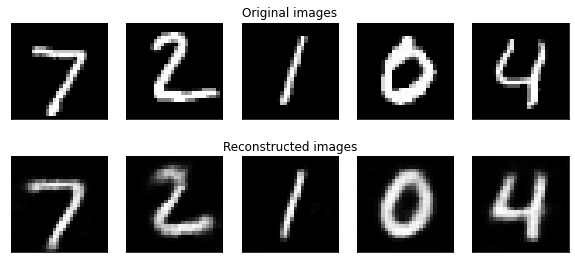

	 partial train loss (single batch): 0.027400
	 partial train loss (single batch): 0.024626
	 partial train loss (single batch): 0.025401
	 partial train loss (single batch): 0.025027
	 partial train loss (single batch): 0.026555
	 partial train loss (single batch): 0.025698
	 partial train loss (single batch): 0.025928
	 partial train loss (single batch): 0.027462
	 partial train loss (single batch): 0.026418
	 partial train loss (single batch): 0.025958
	 partial train loss (single batch): 0.026636
	 partial train loss (single batch): 0.025591
	 partial train loss (single batch): 0.025215
	 partial train loss (single batch): 0.025246
	 partial train loss (single batch): 0.025131
	 partial train loss (single batch): 0.025950
	 partial train loss (single batch): 0.025326
	 partial train loss (single batch): 0.025792
	 partial train loss (single batch): 0.025564
	 partial train loss (single batch): 0.024736
	 partial train loss (single batch): 0.026207
	 partial train loss (single batch

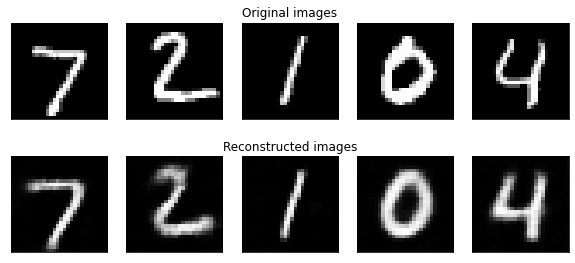

	 partial train loss (single batch): 0.027279
	 partial train loss (single batch): 0.024542
	 partial train loss (single batch): 0.025279
	 partial train loss (single batch): 0.024880
	 partial train loss (single batch): 0.026442
	 partial train loss (single batch): 0.025581
	 partial train loss (single batch): 0.025837
	 partial train loss (single batch): 0.027329
	 partial train loss (single batch): 0.026327
	 partial train loss (single batch): 0.025849
	 partial train loss (single batch): 0.026561
	 partial train loss (single batch): 0.025458
	 partial train loss (single batch): 0.025138
	 partial train loss (single batch): 0.025198
	 partial train loss (single batch): 0.025063
	 partial train loss (single batch): 0.025966
	 partial train loss (single batch): 0.025310
	 partial train loss (single batch): 0.025678
	 partial train loss (single batch): 0.025520
	 partial train loss (single batch): 0.024607
	 partial train loss (single batch): 0.026156
	 partial train loss (single batch

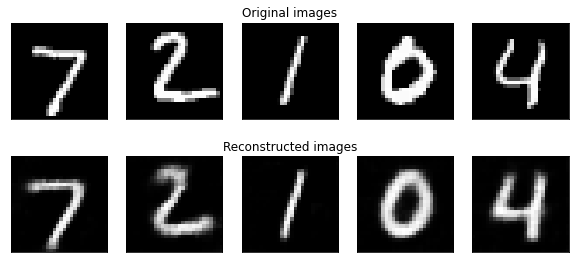

	 partial train loss (single batch): 0.027136
	 partial train loss (single batch): 0.024447
	 partial train loss (single batch): 0.025212
	 partial train loss (single batch): 0.024738
	 partial train loss (single batch): 0.026397
	 partial train loss (single batch): 0.025486
	 partial train loss (single batch): 0.025759
	 partial train loss (single batch): 0.027273
	 partial train loss (single batch): 0.026240
	 partial train loss (single batch): 0.025782
	 partial train loss (single batch): 0.026505
	 partial train loss (single batch): 0.025424
	 partial train loss (single batch): 0.025030
	 partial train loss (single batch): 0.025201
	 partial train loss (single batch): 0.025003
	 partial train loss (single batch): 0.025799
	 partial train loss (single batch): 0.025330
	 partial train loss (single batch): 0.025612
	 partial train loss (single batch): 0.025517
	 partial train loss (single batch): 0.024586
	 partial train loss (single batch): 0.026101
	 partial train loss (single batch

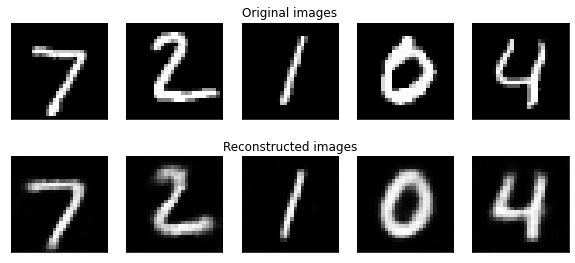

	 partial train loss (single batch): 0.026960
	 partial train loss (single batch): 0.024386
	 partial train loss (single batch): 0.025242
	 partial train loss (single batch): 0.024705
	 partial train loss (single batch): 0.026346
	 partial train loss (single batch): 0.025401
	 partial train loss (single batch): 0.025558
	 partial train loss (single batch): 0.027222
	 partial train loss (single batch): 0.026168
	 partial train loss (single batch): 0.025611
	 partial train loss (single batch): 0.026394
	 partial train loss (single batch): 0.025242
	 partial train loss (single batch): 0.025029
	 partial train loss (single batch): 0.025159
	 partial train loss (single batch): 0.024937
	 partial train loss (single batch): 0.025663
	 partial train loss (single batch): 0.025168
	 partial train loss (single batch): 0.025532
	 partial train loss (single batch): 0.025484
	 partial train loss (single batch): 0.024524
	 partial train loss (single batch): 0.025960
	 partial train loss (single batch

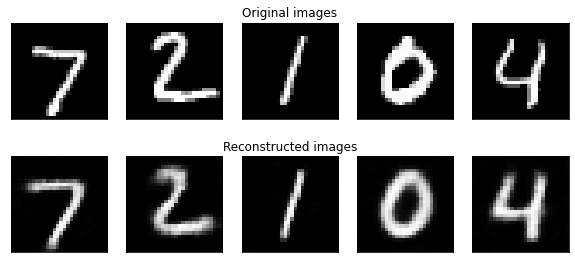

	 partial train loss (single batch): 0.026931
	 partial train loss (single batch): 0.024239
	 partial train loss (single batch): 0.025124
	 partial train loss (single batch): 0.024659
	 partial train loss (single batch): 0.026306
	 partial train loss (single batch): 0.025341
	 partial train loss (single batch): 0.025555
	 partial train loss (single batch): 0.027217
	 partial train loss (single batch): 0.026073
	 partial train loss (single batch): 0.025606
	 partial train loss (single batch): 0.026331
	 partial train loss (single batch): 0.025230
	 partial train loss (single batch): 0.024955
	 partial train loss (single batch): 0.025062
	 partial train loss (single batch): 0.024968
	 partial train loss (single batch): 0.025626
	 partial train loss (single batch): 0.025126
	 partial train loss (single batch): 0.025463
	 partial train loss (single batch): 0.025396
	 partial train loss (single batch): 0.024446
	 partial train loss (single batch): 0.025902
	 partial train loss (single batch

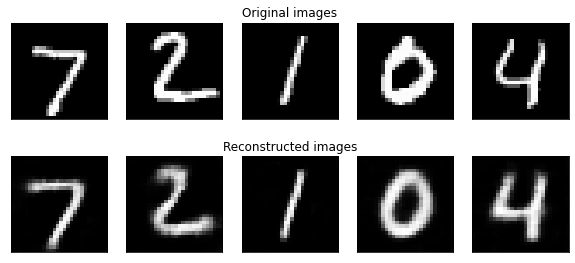

	 partial train loss (single batch): 0.026867
	 partial train loss (single batch): 0.024099
	 partial train loss (single batch): 0.024993
	 partial train loss (single batch): 0.024539
	 partial train loss (single batch): 0.026264
	 partial train loss (single batch): 0.025232
	 partial train loss (single batch): 0.025473
	 partial train loss (single batch): 0.027095
	 partial train loss (single batch): 0.026010
	 partial train loss (single batch): 0.025514
	 partial train loss (single batch): 0.026238
	 partial train loss (single batch): 0.025149
	 partial train loss (single batch): 0.024926
	 partial train loss (single batch): 0.025025
	 partial train loss (single batch): 0.024995
	 partial train loss (single batch): 0.025506
	 partial train loss (single batch): 0.025056
	 partial train loss (single batch): 0.025406
	 partial train loss (single batch): 0.025308
	 partial train loss (single batch): 0.024419
	 partial train loss (single batch): 0.025882
	 partial train loss (single batch

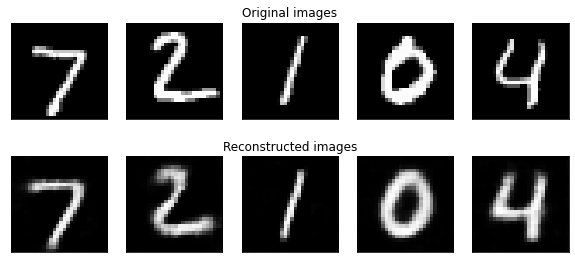

	 partial train loss (single batch): 0.026779
	 partial train loss (single batch): 0.024100
	 partial train loss (single batch): 0.025011
	 partial train loss (single batch): 0.024464
	 partial train loss (single batch): 0.026218
	 partial train loss (single batch): 0.025207
	 partial train loss (single batch): 0.025414
	 partial train loss (single batch): 0.027088
	 partial train loss (single batch): 0.025977
	 partial train loss (single batch): 0.025503
	 partial train loss (single batch): 0.026239
	 partial train loss (single batch): 0.025045
	 partial train loss (single batch): 0.024878
	 partial train loss (single batch): 0.025002
	 partial train loss (single batch): 0.024925
	 partial train loss (single batch): 0.025436
	 partial train loss (single batch): 0.025031
	 partial train loss (single batch): 0.025398
	 partial train loss (single batch): 0.025316
	 partial train loss (single batch): 0.024373
	 partial train loss (single batch): 0.025829
	 partial train loss (single batch

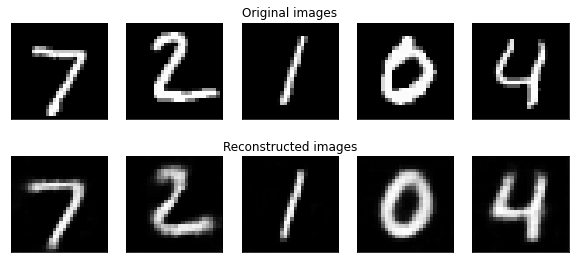

	 partial train loss (single batch): 0.026659
	 partial train loss (single batch): 0.023993
	 partial train loss (single batch): 0.024882
	 partial train loss (single batch): 0.024405
	 partial train loss (single batch): 0.026123
	 partial train loss (single batch): 0.025139
	 partial train loss (single batch): 0.025316
	 partial train loss (single batch): 0.026953
	 partial train loss (single batch): 0.025817
	 partial train loss (single batch): 0.025396
	 partial train loss (single batch): 0.026085
	 partial train loss (single batch): 0.024877
	 partial train loss (single batch): 0.024768
	 partial train loss (single batch): 0.024876
	 partial train loss (single batch): 0.024738
	 partial train loss (single batch): 0.025369
	 partial train loss (single batch): 0.024917
	 partial train loss (single batch): 0.025299
	 partial train loss (single batch): 0.025189
	 partial train loss (single batch): 0.024330
	 partial train loss (single batch): 0.025752
	 partial train loss (single batch

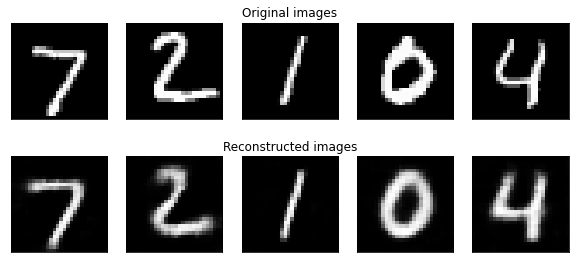

In [34]:
num_epochs = 30
history={'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):

   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,valid_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   history['train_loss'].append(train_loss)
   history['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=5)

In [35]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()

0.026099292561411858

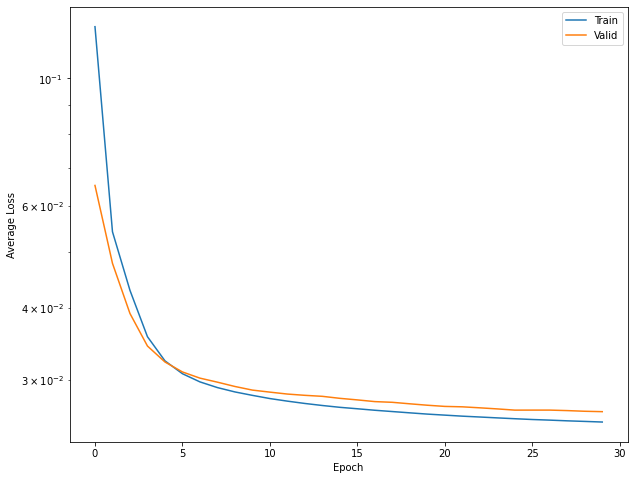

In [36]:
test_epoch(encoder,decoder,device,test_loader,loss_fn).item()# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(history['train_loss'], label='Train')
plt.semilogy(history['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

## 5. Generate new samples from the latent code

In [37]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

In [41]:
plot_reconstructed(decoder, r0=(-1, 1), r1=(-1, 1))

RuntimeError: mat1 dim 1 must match mat2 dim 0

<Figure size 1440x612 with 0 Axes>

## 6. Visualize Latent Code 

In [19]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:09<00:00, 1022.08it/s]


In [20]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-2.268883,1.364354,-0.324822,0.579734,7
1,0.454310,0.688136,1.843909,0.363326,2
2,0.228852,1.283970,-0.108525,0.698502,1
3,-0.180028,-0.964370,0.466799,-0.232247,0
4,-0.556886,-0.119552,-0.489528,-0.667211,4
...,...,...,...,...,...
9995,-0.898000,0.782184,2.056643,1.685823,2
9996,0.931687,0.013393,1.044017,-0.456957,3
9997,-0.570510,0.108823,-0.769197,0.052889,4
9998,0.876379,-0.858239,-1.020191,0.321995,5


In [21]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

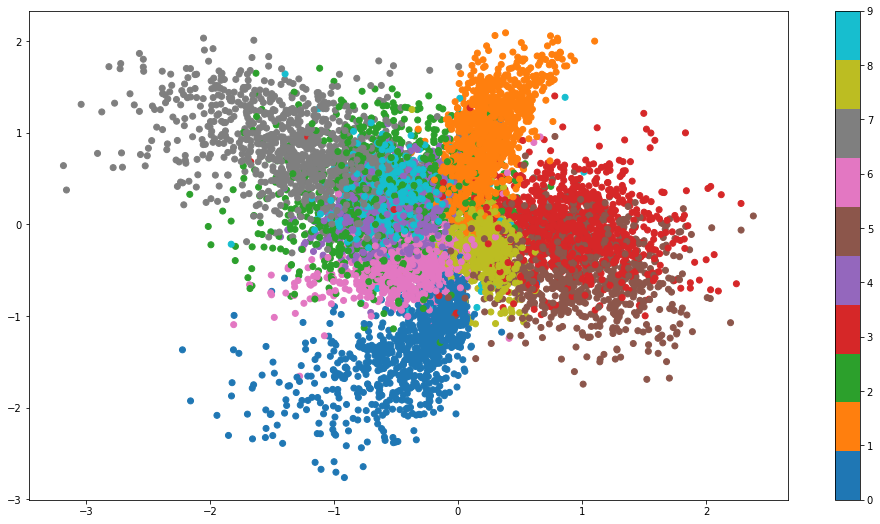

In [22]:
plt.figure(figsize=(17, 9))
plt.scatter(encoded_samples['Enc. Variable 0'], encoded_samples['Enc. Variable 1'], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [23]:
pca = PCA(n_components=2)
components = pca.fit_transform(encoded_samples.drop(['label'],axis=1))
total_var = pca.explained_variance_ratio_.sum() * 100
print(total_var)

62.58848624383147


In [24]:
fig = px.scatter(components, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

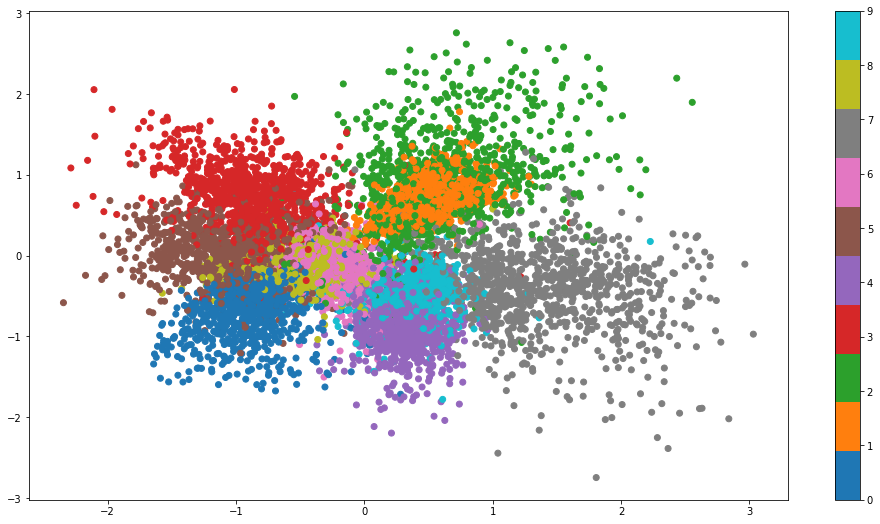

In [25]:
plt.figure(figsize=(17, 9))
plt.scatter(components[:,0], components[:,1], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()

In [26]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [27]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

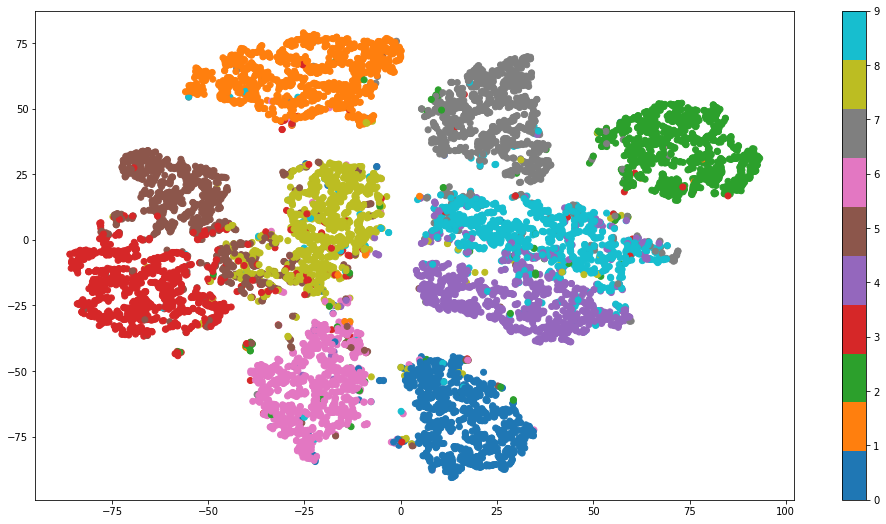

In [28]:
plt.figure(figsize=(17, 9))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10')
plt.colorbar()
plt.show()